In [3]:
from fastai.vision.all import *
path = Path('amazon-data')

In [4]:
# Check the contents of the path
path.ls()

(#4) [Path('amazon-data/sample_submission_v2.csv'),Path('amazon-data/test-jpg'),Path('amazon-data/train-jpg'),Path('amazon-data/train_v2.csv')]

In [5]:
train_df = pd.read_csv(path/'train_v2.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [6]:
train_df.drop(train_df[train_df["tags"] == "cloudy"].index, inplace=True)
train_df.drop(train_df[train_df["tags"].str.contains("habitation")].index, inplace=True)
train_df.drop(train_df[train_df["tags"].str.contains("haze")].index, inplace=True)

In [7]:
import pandas as pd

# lista de labels care sunt deforestare
keywords = ["agriculture","artisinal_mine","conventional_mine","road","cultivation","selective_logging","slash_burn"]

def check_tags(tags):
    for keyword in keywords:
        if keyword in tags:
            return "deforestation"
    return "not_deforestation"

# aplicam functia pe coloana tags pentru a crea coloana label
train_df["label"] = train_df["tags"].apply(check_tags)
train_df

,image_name,tags,label
1,train_1,agriculture clear primary water,deforestation
2,train_2,clear primary,not_deforestation
3,train_3,clear primary,not_deforestation
6,train_6,agriculture clear cultivation primary water,deforestation
8,train_8,agriculture clear cultivation primary,deforestation
...,...,...,...
40472,train_40472,agriculture clear primary,deforestation
40474,train_40474,clear primary,not_deforestation
40476,train_40476,agriculture clear primary,deforestation
40477,train_40477,agriculture clear primary road,deforestation


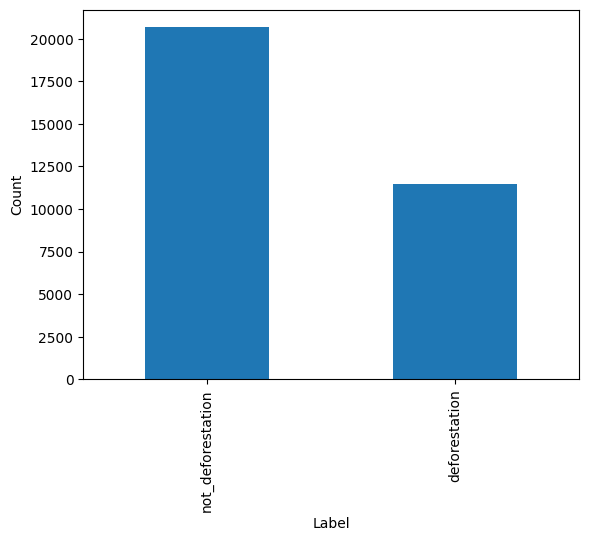

In [8]:
import matplotlib.pyplot as plt

counts = train_df["label"].value_counts()
counts.plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [9]:
counts

label
not_deforestation    20675
deforestation        11487
Name: count, dtype: int64

In [10]:
labels = train_df['label']

In [11]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(2),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


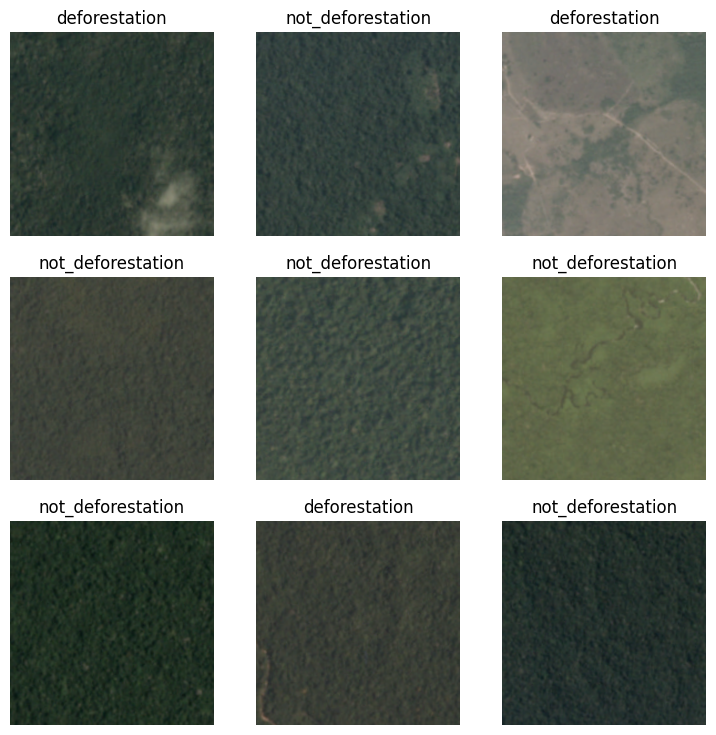

In [12]:
dls = get_data(224,64)
dls.show_batch()

In [13]:
f1score = F1Score(average='binary')
recall = Precision()

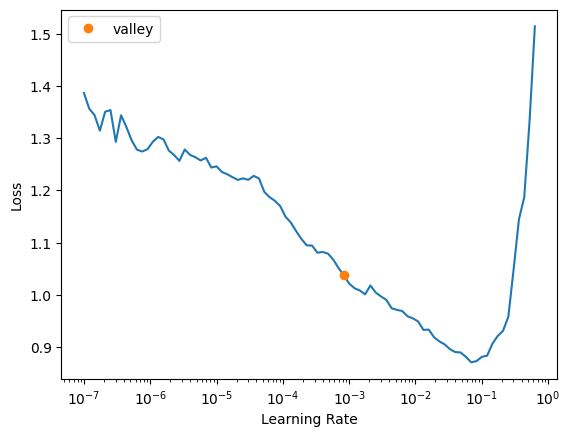

In [20]:
learn = vision_learner(dls, resnet50, metrics=[f1score, recall]).to_fp16()
lr_min = learn.lr_find()

In [23]:
lr_min

SuggestedLRs(valley=0.0008317637839354575)

In [24]:
learn.fine_tune(4, base_lr=0.0008317637839354575,freeze_epochs=4)

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,f1_score,precision_score,time
0,0.534450,0.372942,0.903022,0.906433,1:37:19
1,0.415700,0.311981,0.909241,0.886871,1:36:18
2,0.311243,0.308407,0.900522,0.904588,1:36:51
3,0.303841,0.269634,0.914721,0.888155,1:36:56


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppD

epoch,train_loss,valid_loss,f1_score,precision_score,time
0,0.250399,0.225032,0.924835,0.919856,2:13:19
1,0.213152,0.215953,0.932520,0.922804,2:06:11
2,0.208383,0.204624,0.934058,0.932931,2:03:25
3,0.200804,0.203854,0.933560,0.936056,2:02:56


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppD

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not 

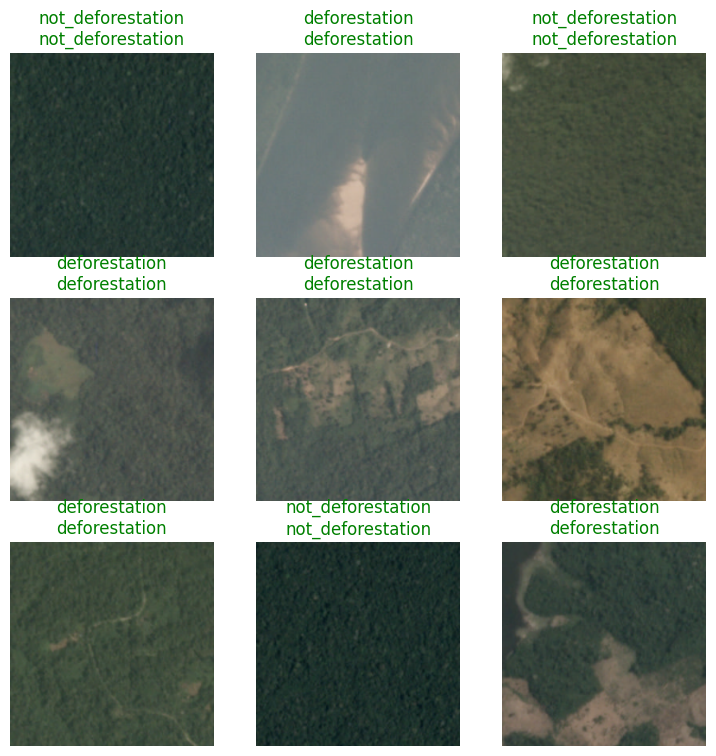

In [25]:
learn.show_results()

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


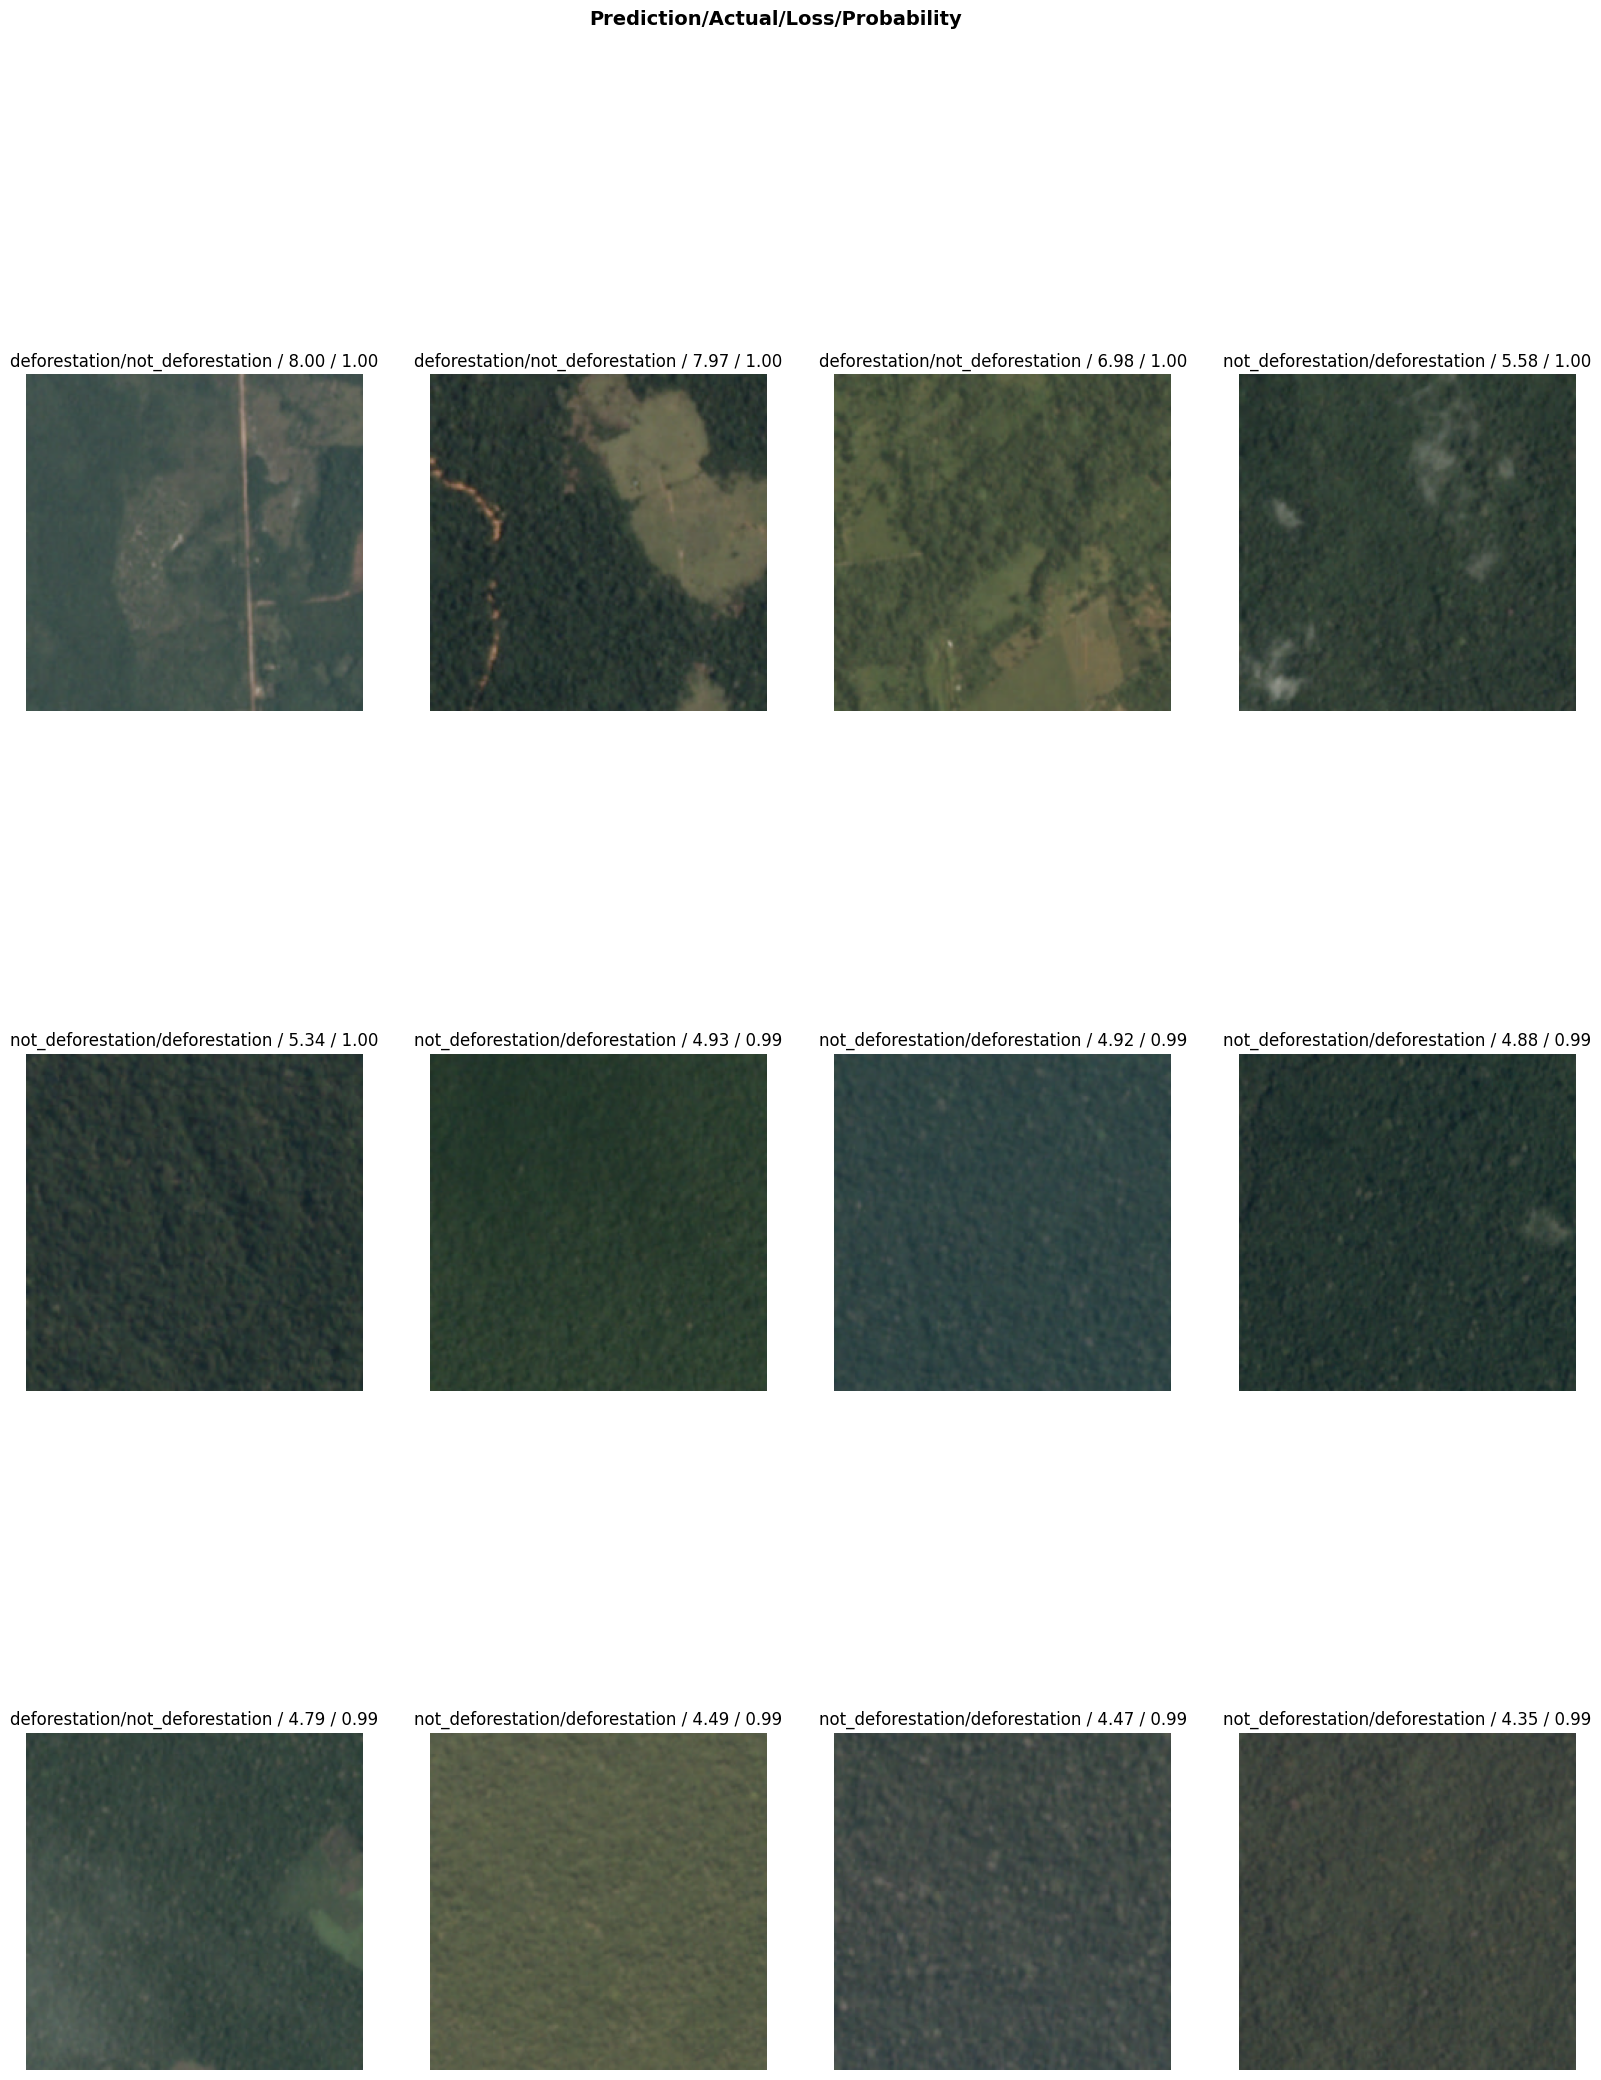

In [27]:
interp.plot_top_losses(12, figsize=(20,25))

C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\cata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


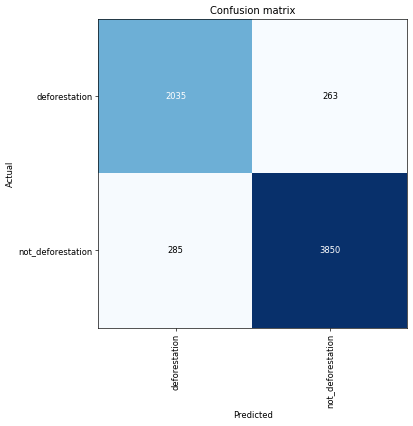

In [28]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [ ]:
learn.export('resnet50_m2.pkl')